# Conditional Kaplan Meier Estimation

Before running the notebook make sure that:

1. Created a python/conda environment according to the specifications
2. Set your working directory (`project_dir`) to the directory where you unpacked the .zip file
3. You might want to add a shebang line to the ./utils (however using it from notebooks with a specified environment should work as well)

The notebook genereates data, trains models and saves them into the ./data directory. Note that at times you will need to overwrite existing files (this is to ensure that you do not accidentally overwrite files that took a long time training - aka. model weights)

See R-Scrips for visualisations (by default, all visualisations should already be in the zip folder)

## Stage 1: Random censoring

In [1]:
project_dir = ''

In [2]:
# Housekeeping
import os
os.chdir(project_dir)

# For data generation
import numpy as np
import pandas as pd
from scipy.stats import gamma

# For standard survival modelling
from lifelines import KaplanMeierFitter

# Model loading
import tensorflow as tf

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

tf.keras.utils.set_random_seed(42)

In [3]:
%load_ext autoreload
%autoreload 2

from main.utils.conditional_km import DeepKaplanMeier

### Data generation

Generate some data according to the specification

In [4]:
size_ = 3000
seed_ = 42
censoring_proportion = 0.2

np.random.seed(seed_)
x_1 = np.random.exponential(0.1, size=size_)
x_2 = np.random.normal(10, np.sqrt(5), size=size_)
x_3 = np.random.poisson(5, size=size_)

features = np.array([x_1, x_2, x_3]).T

# Arrange Targets
survial_model = -3.14*x_1 + 0.318*x_2 + 2.72*x_3

true_survival_time = gamma.rvs(survial_model, scale=1, random_state=seed_)
ceiling_surv_ = np.ceil(true_survival_time)

censored_instances = np.random.uniform(size=size_) > (1-censoring_proportion)
censored_surv = [np.ceil(np.random.uniform()*val_) for val_ in ceiling_surv_[censored_instances]]

observed_survival = ceiling_surv_.copy()
observed_survival[censored_instances] = censored_surv

variable_dict = dict({'true_survival': ceiling_surv_,
                      'observed_survival': observed_survival, 
                      'censoring': censored_instances,
                      'features' :  features})

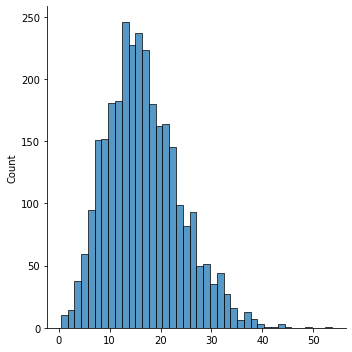

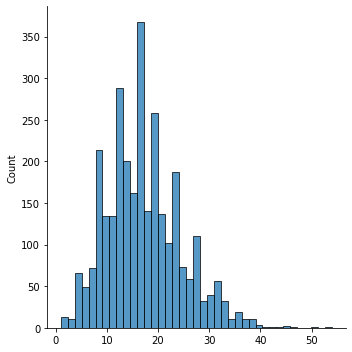

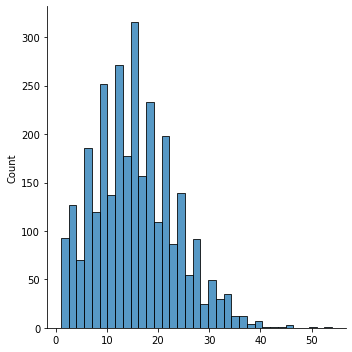

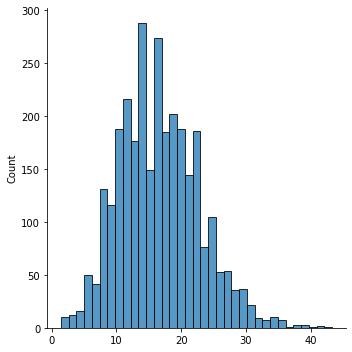

In [5]:
sns.displot(true_survival_time);
sns.displot(ceiling_surv_);
sns.displot(observed_survival);
sns.displot(survial_model);

### Kaplan Meier

In [6]:
kaplan_meier = KaplanMeierFitter()
kaplan_meier.fit(variable_dict['observed_survival'], 
                 ~variable_dict['censoring'])

kaplan_meier_survival = kaplan_meier.survival_function_

# Export for plotting
(kaplan_meier_survival.reset_index()
                      .to_csv('data/random_censoring/estimates_kaplan_meier.csv', 
                      index=False))

### Conditional KM with Neural network

Generate a small picture of the architecture before running the model

In [7]:
%%capture

# Set up model
total_periods = 3

deep_model_simple = DeepKaplanMeier(total_periods)
deep_model_simple.compile_model((3, ), [1,1])

2022-10-20 14:40:37.846776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-20 14:40:37.846872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



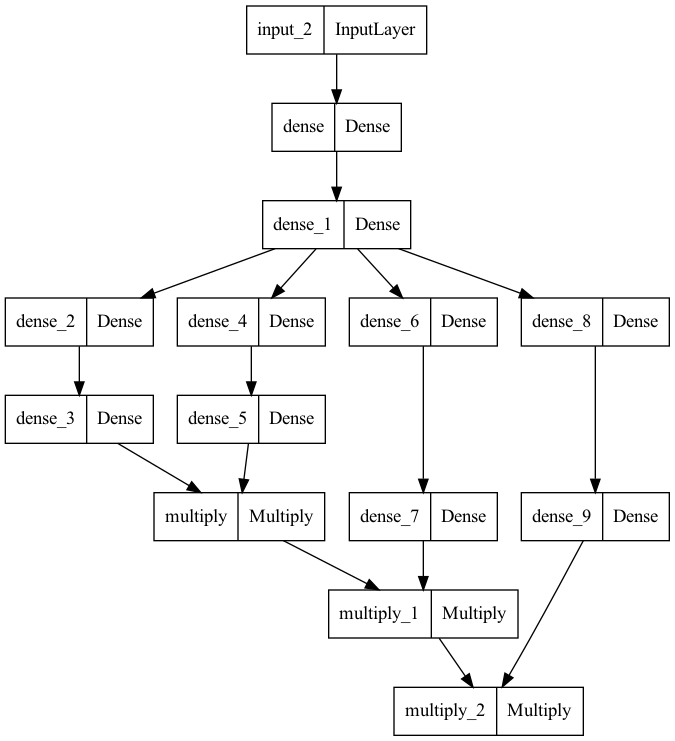

In [8]:
tf.keras.utils.plot_model(deep_model_simple.model)

In [9]:
%%capture

# Set up model, use max observed survival for periods, run a sample model
total_periods = int(variable_dict['observed_survival'].max())

deep_model_simple = DeepKaplanMeier(total_periods)
deep_model_simple.compile_model((3, ), [12, 12])

In [10]:
%%capture
# Fit model
deep_model_simple.fit_model(variable_dict['features'],
                            variable_dict['observed_survival'].astype(int), 
                            variable_dict['censoring'],
                            epochs=100, 
                            verbose=False, 
                            batch_size=256
                            )

2022-10-19 14:04:45.004243: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-19 14:04:50.017267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [11]:
# Run predictions 
predictions_ckm = deep_model_simple.model.predict(variable_dict['features'])

# Predictions are a list for each timeperiod, flatten and create exportable dataframe
ckm_df = (pd.DataFrame(list(map(np.ravel, predictions_ckm)))
          .reset_index()
          .rename(columns={'index':'timeline'}))

# Export
ckm_df.to_csv('data/random_censoring/estimates_conditional_km.csv', 
              index=False)

2022-10-19 14:06:36.529096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 4s 28ms/step


### Individual predictions of CKM

In [12]:
# Select some examples
print('Mean survival',
      np.round(variable_dict['true_survival'].mean(), 2))
mean_true = np.round(variable_dict['true_survival'].mean()) 
lower = mean_true - 10
upper = mean_true + 10

want_list = [lower, upper]

for idx, value in enumerate(variable_dict['true_survival']):
    if value in want_list:
        print(idx, value)
        want_list.remove(value)

Mean survival 17.14
37 7.0
71 27.0


### Unconditional KM with Neural Net

In [13]:
%%capture

# Set up model
total_periods = int(variable_dict['observed_survival'].max())

deep_model_linear = DeepKaplanMeier(total_periods)
deep_model_linear.compile_model((1, ), [12,12], activation='linear')

In [14]:
dummy_features_ = np.repeat(1, size_).reshape(size_,1)

In [15]:
# Fit model
deep_model_linear.fit_model(dummy_features_,
                            variable_dict['observed_survival'].astype(int), 
                            variable_dict['censoring'],
                            epochs=100,
                            verbose=False, 
                            batch_size=256
                            )

2022-10-19 14:06:48.168704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [16]:
# Run predictions 
predictions_ckm = deep_model_linear.model.predict(dummy_features_)

# Predictions are a list for each timeperiod, flatten and create exportable dataframe
ckm_df = (pd.DataFrame(list(map(np.ravel, predictions_ckm)))
          .reset_index()
          .rename(columns={'index':'timeline'}))

# Export
ckm_df.to_csv('data/random_censoring/estimates_unconditional_deep_km.csv', 
              index=False)

2022-10-19 14:08:45.300309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 4s 30ms/step


### Simulated data for plotting

In [10]:
true_data = (pd.DataFrame({'surv_time' : variable_dict['true_survival']})
             .groupby('surv_time')
             .agg({'surv_time': 'count'})
             .rename(columns={'surv_time': 'failures'})
             .reset_index())

true_data['relative'] = true_data.failures / size_
true_data['survival'] = 1-np.cumsum(true_data.relative)
true_data = true_data[['surv_time', 'survival']]
true_data = (true_data
             .append(pd.DataFrame({'surv_time': [0], 'survival':[1]}))
             .reset_index()
             .sort_values('surv_time'))

(true_data[['surv_time', 'survival']].rename(columns={'surv_time': 'timeline'})
                                     .to_csv('data/random_censoring/true_data.csv', 
                                     index=False))

/var/folders/jy/l1h7n_nx6sl3h96lm_0n3ppc0000gn/T/ipykernel_6215/2703069891.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  true_data = (true_data
